# Exercise 6: ARMA and GARCH models

**_Group: Ducray, Razanajatovo_**

<br/>
<div style="text-align: justify">Please find below our study on Apple's daily price log returns. We aimed at fitting the optimal AR-GARCH model using both expanding and recursive windows to forecast the latter.</div>

<br/>
<div style="text-align: justify">The code breaks down in 4 main steps: data preparation, Box-Jenkins approach for ARMA and GARCH process', forecasting analysis, and VaR computation.</div>

## Step 1: Data Preparation

In [1]:
#================== Import Libraries ===================

# Standard math packages
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm
from scipy.stats import t

# Standard econometrics packges
from statsmodels.tsa.stattools import adfuller
from itertools import product
from statsmodels import tsa
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
!pip install arch
from arch import arch_model

import warnings
warnings.filterwarnings("ignore")

In [2]:
#============== Load and prepare data ================

# Import data
df = pd.read_excel('AAPL.xlsx',index_col=0)
# Sort data in chronological order
df = df.sort_values(by='Date', ascending=True)
# Compute the daily log returns on Apple stock prices
df_logret = np.log(df['Adj Close'].iloc[1:]).diff().dropna()*100
df_logret
# Split data into train (in-sample, from 01/01/2018 to 31/08/2022) and  test(out-sample, i.e. from 01/09/2022 to 21/12/2022) dataframes:
df_train = df_logret.loc['2018-01-04':'2022-08-31' ]
df_test = df_logret.loc['2022-09-01':'2022-12-21']

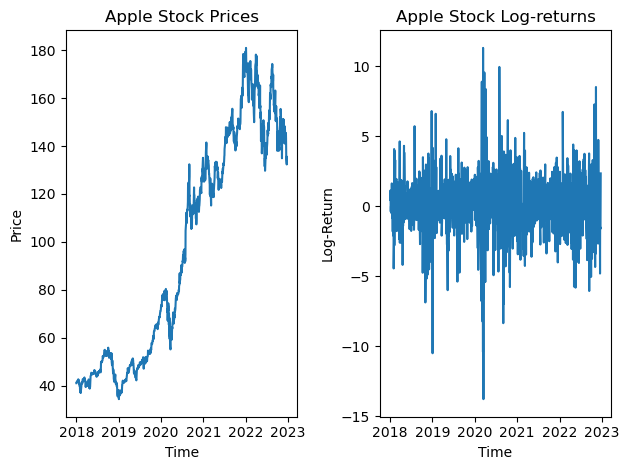

In [3]:
#================== Visual representation ===================

# Check the stock price's fluctuation
plt.subplot(1, 2, 1)
plt.plot(df['Adj Close'])
plt.title("Apple Stock Prices")
plt.xlabel('Time')
plt.ylabel('Price')
# Check the evolution of log-returns
plt.subplot(1, 2, 2)
plt.plot(df_logret)
plt.title("Apple Stock Log-returns")
plt.xlabel('Time')
plt.ylabel('Log-Return')
plt.tight_layout()

## Step 2: Fit ARMA and GARCH models

In [4]:
#================== Stationary Assumption Test: Augmented Dickey-Fuller ===================

# Run ADF test and present outputs in a straightforward dataframe
test = adfuller(df_logret)
df_adf = pd.DataFrame(index=['Test Statistic Value', "p-value", "Lags Used", "Number of Observations Used","Critical Value(1%)","Critical Value(5%)","Critical Value(10%)"],columns=['Output'])
df_adf['Output']['Test Statistic Value'] = test[0]
df_adf['Output']['p-value'] = test[1]
df_adf['Output']['Lags Used'] = test[2]
df_adf['Output']['Number of Observations Used'] = test[3]
df_adf['Output']['Critical Value(1%)'] = test[4]['1%']
df_adf['Output']['Critical Value(5%)'] = test[4]['5%']
df_adf['Output']['Critical Value(10%)'] = test[4]['10%']
df_adf

,Output
Test Statistic Value,-11.082035
p-value,0.0
Lags Used,8
Number of Observations Used,1242
Critical Value(1%),-3.435626
Critical Value(5%),-2.86387
Critical Value(10%),-2.56801


<div style="text-align: justify">The null hypothesis is rejected since the test's p-value is below the 1% threshold. Therefore, the process is <strong>stationary</strong> and data's properties are fit for forecasting inference.</div> 

fitting: ar:0 - ma:0
fitting: ar:1 - ma:0
fitting: ar:2 - ma:0
fitting: ar:3 - ma:0
fitting: ar:4 - ma:0
fitting: ar:5 - ma:0
fitting: ar:6 - ma:0
fitting: ar:7 - ma:0
fitting: ar:8 - ma:0
fitting: ar:9 - ma:0
fitting: ar:10 - ma:0
criterion
     ar_order  ma_order       aic       bic
0          0         0  5.053090  5.063224
1          1         0  5.038805  5.054007
2          2         0  5.040738  5.061007
3          3         0  5.042510  5.067846
4          4         0  5.044367  5.074771
5          5         0  5.044317  5.079789
6          6         0  5.043284  5.083823
7          7         0  5.030840  5.076446
8          8         0  5.020024  5.070697
9          9         0  5.014500  5.070241
10        10         0  5.016271  5.077079

The optimal ARMA model to fit Apple daily log returns is the ARMA(1, 0)


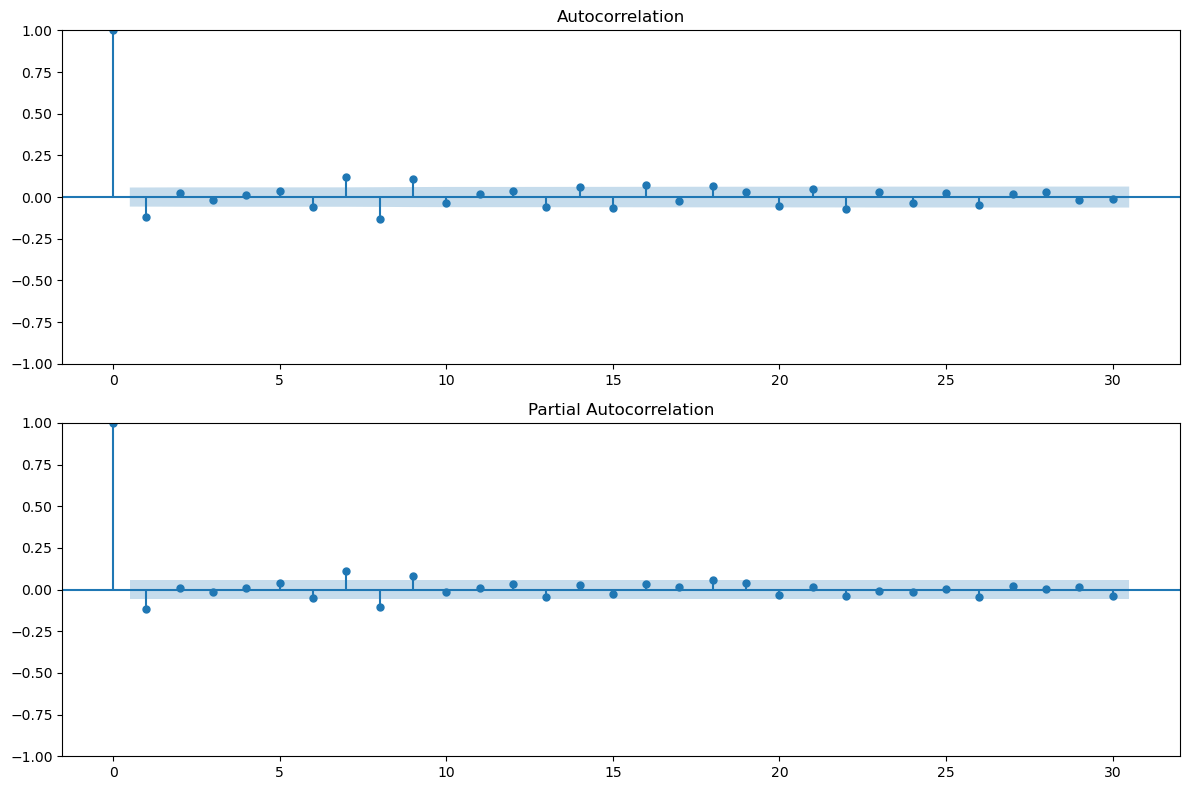

In [5]:
#================== Box-Jenkins Method to fit ARIMA process ===================

## Identification: Choose optimal parameters orders based on ACF/PACF and information criterions 

# Graphical analysis
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_train, lags=30, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_train, lags=30, ax=ax2)
plt.tight_layout()

# Parameters AIC/BIC analysis
ar_order = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
ma_order = [0]
arma_res = [list(orders) for orders in product(ar_order, ma_order)]

## Estimation: Fit ARMA model on train dataset
for n in arma_res:
    print('fitting: ar:{} - ma:{}'.format(*n)) 
    try:
        arma_model  = tsa.arima.model.ARIMA(df_train, order= (n[0], 0, 0)).fit()
        ## Diagnostic: Compute and analyze the information criterion + Stationarity confirmed with ADF
        n.extend([arma_model.aic / 1e3, arma_model.bic / 1e3])
    except Exception as exception:
        print(exception.__str__())
        n.extend([np.NaN, np.NaN])
    
res = pd.DataFrame(arma_res, columns = ['ar_order', 'ma_order', 'aic', 'bic'])
print('criterion\n', res)

# Confirm the optimal parameter order 
opti_order = sm.tsa.arma_order_select_ic(df_train,max_ar=10,max_ma=0,ic='bic')['bic_min_order']
print()
print(f'The optimal ARMA model to fit Apple daily log returns is the ARMA{opti_order}')

<div style="text-align: justify">Despite unclear graphical inference, the AIC/BIC criterion allow us to identify <strong>ARMA(1,0) model as the best fit</strong> for our data. Although the geometrical decay isn't obvious graphically, this result matches the significant spike on PACF's first lag.</div>

**PAUL: Je sais qu'on doit tester pour AR-GARCH mais je me dis que c'est plus cohérent de parler en ARMA(1,0) malgré tout dans l'analyse**

In [6]:
#===== Analyze for GARCH effects using the Jarque-Bera test on the standardized residuals =======================

# Compute standardized residuals
df_train_std = (df_train - np.mean(df_train))/ np.std(df_train)
nb_obs = len(df_train_std)

# Run the Jarque-Bera test on standardized residuals
jb = sm.stats.stattools.jarque_bera(df_train_std, axis=0)
df_jb = pd.DataFrame(index=['T-stat', "P-value", "Skewness", "Kurtosis"],columns=['Output'])
df_jb['Output']['T-stat'] = jb[0]
df_jb['Output']['P-value'] = jb[1]
df_jb['Output']['Skewness'] = jb[2]
df_jb['Output']['Kurtosis'] = jb[3]
print(df_jb)

# ON FAIT QUOI LAAAAAA ?????
mw_size = 250
jb_mw = np.zeros(nb_obs-mw_size)
for x in range(0, nb_obs-mw_size):
    jb =  sm.stats.stattools.jarque_bera(df_train_std[x:mw_size+x], axis=0)  
    jb_mw [x] = jb[1]
    
np.mean(jb_mw < 0.05)

               Output
T-stat    1252.198439
P-value           0.0
Skewness    -0.319214
Kurtosis     8.021239


0.8699891657638137

<div style="text-align: justify">The Jarque-Bera tests the model's goodness-of-fit and indicates on its distribution. Since the p-value is below the 1% threshold, we <strong> reject the null hypothesis</strong> of residuals' normal distribution. Therefore, we confirm the presence of a GARCH effect. One could use a different distribution for GARCH, one with fatter tails and that takes into account the skewness.</div>

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6120.618619810915
Iteration:      2,   Func. Count:     17,   Neg. LLF: 53504.76858442735
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2603.476890726491
Iteration:      4,   Func. Count:     35,   Neg. LLF: 2575.4654742821367
Iteration:      5,   Func. Count:     43,   Neg. LLF: 2359.882528014747
Iteration:      6,   Func. Count:     50,   Neg. LLF: 2356.158847283118
Iteration:      7,   Func. Count:     56,   Neg. LLF: 2356.071056896617
Iteration:      8,   Func. Count:     62,   Neg. LLF: 2356.062944012455
Iteration:      9,   Func. Count:     68,   Neg. LLF: 2356.060876646876
Iteration:     10,   Func. Count:     74,   Neg. LLF: 2356.060535233218
Iteration:     11,   Func. Count:     80,   Neg. LLF: 2356.0604717099127
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2356.060471709904
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2356.0604717099127
            Iterations: 1

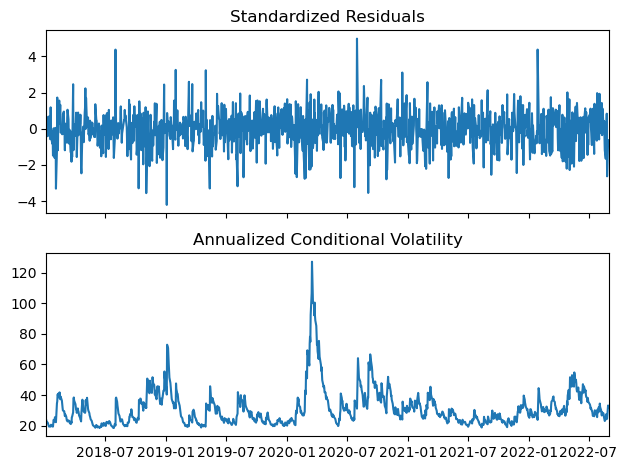

In [7]:
#===== GARCH(1,1) model fit and analysis =======================

# Run the model and analyze its parameters
arch = arch_model(df_train,p=1, o=0, q=1, mean='AR', lags=0, dist='t') 
res = arch.fit()
print(res.summary())
# Fine tune the analysis with visual representation of residuals' behavior
fig = res.plot(annualize='D')
fig.tight_layout()

Looking at this summary, we can conclude the presence of a GARCH(1,1).

**PAUL for Ariane: Presence of GARCH(1,1) bc the param are signif diff from 0?**
I must review the course maybe but how do you identify or choose the params? Only using the AR(1) optimal param and the presence of GARCH effect ?

## Step 3: Forcasting 1- and 20-steps ahead:

In [76]:
#===== Key forecasting functions =======================

def fixed_window(steps, df_test, df):
    idx = df_test.index
    data_shifted = df.shift(steps).loc[idx].apply(np.log)

    arma_model  = tsa.arima.model.ARIMA(df_train, order=(1,0,0)).fit()
    garch_res = arch_model(df_train_std,p=1, o=0, q=1, mean='AR', lags=0, dist='t').fit()

    forecast_arma = arma_model.predict(n_periods=steps)[0]

    forecast_garch = garch_res.forecast(horizon=steps, reindex=False)
    predicted_et = forecast_garch.mean['h.'+ str(steps)].iloc[-1]

    prediction = forecast_arma + predicted_et
    prediction = pd.DataFrame(prediction, columns=['Fixed'], index=idx).cumsum()
    
    return prediction

def recursive_window(steps, df_test, df):
    forecast = []
    idx = df_test.index
    data_shifted = df.shift(steps).loc[idx].apply(np.log)
    for dt in df_test.index:
        data = df_logret.loc[df_logret.index < dt]
        # Fit an ARMA on data and GARCH on its residuals
        arma_model  = tsa.arima.model.ARIMA(data, order=(1,0,0)).fit()
        garch_res = arch_model(data,p=1, o=0, q=1, mean='AR', lags=0, dist='t').fit()
        # Forecast values for both models for inputed steps
        forecast_arma = arma_model.predict(n_periods=steps)[0]
        forecast_garch = garch_res.forecast(horizon=steps, reindex=False)
        predicted_et = forecast_garch.mean['h.'+ str(steps)].iloc[-1]
        # Define the prediction output 
        prediction = forecast_arma + predicted_et
        forecast.append(prediction.tolist())

    forecast = pd.DataFrame(forecast, columns=['Recursive'], index=idx)
    return forecast

def rolling_window(steps,df_test,df):
    forecast = []
    roll_freq = 200
    idx = df_test.index
    data_shifted = df.shift(steps).loc[idx].apply(np.log)
    
    for dt in df_test.index:
        data = df_logret.loc[df_logret.index < dt]
        arma_model  = tsa.arima.model.ARIMA(data.iloc[-roll_freq:], order=(1,0,0)).fit()
        garch_res = arch_model(data,p=1, o=0, q=1, mean='AR', lags=0, dist='t').fit()

        forecast_arma = arma_model.predict(n_periods=steps)[0]
        forecast_garch = garch_res.forecast(horizon=steps, reindex=False)
        predicted_et = forecast_garch.mean['h.'+ str(steps)].iloc[-1]

        prediction = forecast_arma + predicted_et
        forecast.append(prediction.tolist())

    forecast = pd.DataFrame(forecast, columns=['Rolling'], index=idx)
    return forecast

In [45]:
#===== 1-step ahead forecasts =======================

# Adjusted close price
obs = df.loc[df_test.index].apply(np.log)

# Fixed window forecast
forecast_fixed = fixed_window(1, df_test, df).add(data_shifted.squeeze(),axis=0)

# Recursive window forecast
forecast_recursive = recursive_window(1, df_test, df).add(data_shifted.squeeze(),axis=0)

# Rolling window forecast
forecast_rolling = rolling_window(1, df_test, df).add(data_shifted.squeeze(),axis=0)

# Global forecast overview by merging outputs
list = [forecast_recursive,forecast_rolling, obs]
forecast_overview = forecast_fixed
for i in range(len(list)):
    forecast_overview = pd.merge(forecast_overview,list[i], left_index=True, right_index=True)
forecast_overview

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6988.224375263742
Iteration:      2,   Func. Count:     17,   Neg. LLF: 50688.788218607224
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2035.7967747452835
Iteration:      4,   Func. Count:     34,   Neg. LLF: 2907.450255764102
Iteration:      5,   Func. Count:     42,   Neg. LLF: 2613.0891693163844
Iteration:      6,   Func. Count:     49,   Neg. LLF: 1495.985268203405
Iteration:      7,   Func. Count:     55,   Neg. LLF: 1495.939629341462
Iteration:      8,   Func. Count:     61,   Neg. LLF: 1495.93267560625
Iteration:      9,   Func. Count:     67,   Neg. LLF: 1495.9308522110632
Iteration:     10,   Func. Count:     73,   Neg. LLF: 1495.9306202116882
Iteration:     11,   Func. Count:     79,   Neg. LLF: 1495.9305506424141
Iteration:     12,   Func. Count:     85,   Neg. LLF: 1495.9305500126916
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1495.9305500126916
            Iteration

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6191.469523541744
Iteration:      2,   Func. Count:     17,   Neg. LLF: 53530.82341780863
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2618.0613586163918
Iteration:      4,   Func. Count:     35,   Neg. LLF: 2589.2360442809377
Iteration:      5,   Func. Count:     43,   Neg. LLF: 2400.9612177161716
Iteration:      6,   Func. Count:     50,   Neg. LLF: 2376.1381032933723
Iteration:      7,   Func. Count:     56,   Neg. LLF: 2375.9458284410453
Iteration:      8,   Func. Count:     62,   Neg. LLF: 2375.9206818712287
Iteration:      9,   Func. Count:     68,   Neg. LLF: 2375.916051058729
Iteration:     10,   Func. Count:     74,   Neg. LLF: 2375.91529843062
Iteration:     11,   Func. Count:     80,   Neg. LLF: 2375.914997532019
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2375.9149975320215
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2375.914997532019
            Iterations

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6242.3142258467815
Iteration:      2,   Func. Count:     17,   Neg. LLF: 53612.31732509449
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2638.2713224743447
Iteration:      4,   Func. Count:     35,   Neg. LLF: 2611.251204168425
Iteration:      5,   Func. Count:     43,   Neg. LLF: 2448.5868604725415
Iteration:      6,   Func. Count:     50,   Neg. LLF: 2394.0858988836953
Iteration:      7,   Func. Count:     56,   Neg. LLF: 2393.90403991599
Iteration:      8,   Func. Count:     62,   Neg. LLF: 2393.8832135359953
Iteration:      9,   Func. Count:     68,   Neg. LLF: 2393.879297123193
Iteration:     10,   Func. Count:     74,   Neg. LLF: 2393.8786702704856
Iteration:     11,   Func. Count:     80,   Neg. LLF: 2393.878427884586
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2393.8784278845887
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2393.878427884586
            Iterations

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6348.370114392085
Iteration:      2,   Func. Count:     17,   Neg. LLF: 54083.76995541248
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2675.207719868928
Iteration:      4,   Func. Count:     34,   Neg. LLF: 2632.173730165736
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3561.871199612451
Iteration:      6,   Func. Count:     49,   Neg. LLF: 2417.498420413651
Iteration:      7,   Func. Count:     55,   Neg. LLF: 2417.3763646736197
Iteration:      8,   Func. Count:     61,   Neg. LLF: 2417.359206793298
Iteration:      9,   Func. Count:     67,   Neg. LLF: 2417.3563292261183
Iteration:     10,   Func. Count:     73,   Neg. LLF: 2417.3557026187086
Iteration:     11,   Func. Count:     79,   Neg. LLF: 2417.3555334224416
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2417.355532726352
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2417.355532726352
            Iterations: 

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6387.666015310387
Iteration:      2,   Func. Count:     17,   Neg. LLF: 54463.33066052478
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2691.401564907676
Iteration:      4,   Func. Count:     35,   Neg. LLF: 2652.856539469685
Iteration:      5,   Func. Count:     43,   Neg. LLF: 2545.5883662883725
Iteration:      6,   Func. Count:     50,   Neg. LLF: 2436.4792391430074
Iteration:      7,   Func. Count:     56,   Neg. LLF: 2436.2788547017117
Iteration:      8,   Func. Count:     62,   Neg. LLF: 2436.255901781861
Iteration:      9,   Func. Count:     68,   Neg. LLF: 2436.2516177485945
Iteration:     10,   Func. Count:     74,   Neg. LLF: 2436.251009329122
Iteration:     11,   Func. Count:     80,   Neg. LLF: 2436.250797921005
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2436.2507979210077
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2436.250797921005
            Iterations:

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6429.071502072134
Iteration:      2,   Func. Count:     17,   Neg. LLF: 55971.37281655866
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2715.9021011616064
Iteration:      4,   Func. Count:     34,   Neg. LLF: 2678.6392146404633
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3629.578439363765
Iteration:      6,   Func. Count:     49,   Neg. LLF: 2461.9261310109036
Iteration:      7,   Func. Count:     55,   Neg. LLF: 2461.811530668352
Iteration:      8,   Func. Count:     61,   Neg. LLF: 2461.797084207637
Iteration:      9,   Func. Count:     67,   Neg. LLF: 2461.7942083333755
Iteration:     10,   Func. Count:     73,   Neg. LLF: 2461.7936487198763
Iteration:     11,   Func. Count:     79,   Neg. LLF: 2461.7935261156135
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2461.7935255414386
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2461.7935255414386
            Iteratio

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6451.741259568644
Iteration:      2,   Func. Count:     17,   Neg. LLF: 55622.03591390703
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2738.4655129003395
Iteration:      4,   Func. Count:     34,   Neg. LLF: 2704.530100886028
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3634.4448941503338
Iteration:      6,   Func. Count:     49,   Neg. LLF: 2486.5109991884283
Iteration:      7,   Func. Count:     55,   Neg. LLF: 2486.322709767721
Iteration:      8,   Func. Count:     61,   Neg. LLF: 2486.2981635329998
Iteration:      9,   Func. Count:     67,   Neg. LLF: 2486.292856039431
Iteration:     10,   Func. Count:     73,   Neg. LLF: 2486.2920835164014
Iteration:     11,   Func. Count:     79,   Neg. LLF: 2486.291847504606
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2486.2918468743637
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2486.2918468743637
            Iteration

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6537.517048795715
Iteration:      2,   Func. Count:     17,   Neg. LLF: 54997.601041749294
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2773.0258871540414
Iteration:      4,   Func. Count:     34,   Neg. LLF: 2720.469419793555
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3662.492513464984
Iteration:      6,   Func. Count:     49,   Neg. LLF: 2505.6316769558457
Iteration:      7,   Func. Count:     55,   Neg. LLF: 2505.4746840434445
Iteration:      8,   Func. Count:     61,   Neg. LLF: 2505.4541592350106
Iteration:      9,   Func. Count:     67,   Neg. LLF: 2505.4503779859206
Iteration:     10,   Func. Count:     73,   Neg. LLF: 2505.4497713448754
Iteration:     11,   Func. Count:     79,   Neg. LLF: 2505.4495972691793
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2505.449596687074
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2505.449596687074
            Iteratio

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6574.378595818802
Iteration:      2,   Func. Count:     17,   Neg. LLF: 55435.37646544851
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2795.9917479286487
Iteration:      4,   Func. Count:     34,   Neg. LLF: 2740.081522979368
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3680.551412901895
Iteration:      6,   Func. Count:     49,   Neg. LLF: 2524.6776105000163
Iteration:      7,   Func. Count:     55,   Neg. LLF: 2524.521152735422
Iteration:      8,   Func. Count:     61,   Neg. LLF: 2524.4989783585206
Iteration:      9,   Func. Count:     67,   Neg. LLF: 2524.4952441108526
Iteration:     10,   Func. Count:     73,   Neg. LLF: 2524.4946343410365
Iteration:     11,   Func. Count:     79,   Neg. LLF: 2524.494450507138
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2524.494449942543
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2524.494449942543
            Iterations:

Iteration:      9,   Func. Count:     68,   Neg. LLF: 2364.180074519385
Iteration:     10,   Func. Count:     74,   Neg. LLF: 2364.1797322899192
Iteration:     11,   Func. Count:     80,   Neg. LLF: 2364.179661065302
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2364.1796610652923
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2364.179661065302
            Iterations: 12
            Function evaluations: 85
            Gradient evaluations: 12
Iteration:      1,   Func. Count:      7,   Neg. LLF: 6141.062490217768
Iteration:      2,   Func. Count:     17,   Neg. LLF: 53443.279740096885
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2614.19236641515
Iteration:      4,   Func. Count:     35,   Neg. LLF: 2587.606567215485
Iteration:      5,   Func. Count:     43,   Neg. LLF: 2369.571024355647
Iteration:      6,   Func. Count:     50,   Neg. LLF: 2366.330539133982
Iteration:      7,   Func. Count:     56,   Neg. LLF: 2366.2566922196

Iteration:      5,   Func. Count:     43,   Neg. LLF: 2487.202969819906
Iteration:      6,   Func. Count:     50,   Neg. LLF: 2395.5646519109687
Iteration:      7,   Func. Count:     57,   Neg. LLF: 2395.3671091381766
Iteration:      8,   Func. Count:     63,   Neg. LLF: 2395.3632967988033
Iteration:      9,   Func. Count:     69,   Neg. LLF: 2395.3623972322025
Iteration:     10,   Func. Count:     75,   Neg. LLF: 2395.362134144337
Iteration:     11,   Func. Count:     81,   Neg. LLF: 2395.3621296986944
Iteration:     12,   Func. Count:     86,   Neg. LLF: 2395.3621296986894
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2395.3621296986944
            Iterations: 12
            Function evaluations: 86
            Gradient evaluations: 12
Iteration:      1,   Func. Count:      7,   Neg. LLF: 6250.611329250254
Iteration:      2,   Func. Count:     17,   Neg. LLF: 53496.35870738944
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2642.86755

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6380.462878136541
Iteration:      2,   Func. Count:     17,   Neg. LLF: 54612.12921621776
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2689.1134372088572
Iteration:      4,   Func. Count:     34,   Neg. LLF: 2644.517413282694
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3580.0441846665112
Iteration:      6,   Func. Count:     49,   Neg. LLF: 2428.899733198353
Iteration:      7,   Func. Count:     55,   Neg. LLF: 2428.7808841599217
Iteration:      8,   Func. Count:     61,   Neg. LLF: 2428.764855052795
Iteration:      9,   Func. Count:     67,   Neg. LLF: 2428.7622817136316
Iteration:     10,   Func. Count:     73,   Neg. LLF: 2428.76174076035
Iteration:     11,   Func. Count:     79,   Neg. LLF: 2428.7615992383353
Iteration:     12,   Func. Count:     84,   Neg. LLF: 2428.761599238339
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2428.7615992383353
            Iterations:

Iteration:      2,   Func. Count:     17,   Neg. LLF: 55886.29064911949
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2706.7931409529147
Iteration:      4,   Func. Count:     34,   Neg. LLF: 2676.00358516103
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3620.2871891400428
Iteration:      6,   Func. Count:     49,   Neg. LLF: 2458.7855769414546
Iteration:      7,   Func. Count:     55,   Neg. LLF: 2458.663237294524
Iteration:      8,   Func. Count:     61,   Neg. LLF: 2458.6465118561587
Iteration:      9,   Func. Count:     67,   Neg. LLF: 2458.643107326953
Iteration:     10,   Func. Count:     73,   Neg. LLF: 2458.642436156135
Iteration:     11,   Func. Count:     79,   Neg. LLF: 2458.6422875328603
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2458.6422869023727
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2458.6422869023727
            Iterations: 12
            Function evaluations: 85
            Gradient evaluatio

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6463.681842161649
Iteration:      2,   Func. Count:     17,   Neg. LLF: 55262.42713172511
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2742.16196960906
Iteration:      4,   Func. Count:     34,   Neg. LLF: 2706.6912335663883
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3637.18626900058
Iteration:      6,   Func. Count:     49,   Neg. LLF: 2490.4865793932995
Iteration:      7,   Func. Count:     55,   Neg. LLF: 2490.2941816647212
Iteration:      8,   Func. Count:     61,   Neg. LLF: 2490.267634948451
Iteration:      9,   Func. Count:     67,   Neg. LLF: 2490.262018685225
Iteration:     10,   Func. Count:     73,   Neg. LLF: 2490.261152700098
Iteration:     11,   Func. Count:     79,   Neg. LLF: 2490.260881400119
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2490.2608805316777
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2490.2608805316777
            Iterations: 1

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6555.700637091807
Iteration:      2,   Func. Count:     17,   Neg. LLF: 55673.836822995174
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2785.016687881311
Iteration:      4,   Func. Count:     34,   Neg. LLF: 2733.409127230748
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3675.5667397103052
Iteration:      6,   Func. Count:     49,   Neg. LLF: 2517.5512114665044
Iteration:      7,   Func. Count:     55,   Neg. LLF: 2517.377523345058
Iteration:      8,   Func. Count:     61,   Neg. LLF: 2517.355072450851
Iteration:      9,   Func. Count:     67,   Neg. LLF: 2517.350968567942
Iteration:     10,   Func. Count:     73,   Neg. LLF: 2517.350385649048
Iteration:     11,   Func. Count:     79,   Neg. LLF: 2517.350212974082
Iteration:     12,   Func. Count:     84,   Neg. LLF: 2517.3502129740855
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2517.350212974082
            Iterations: 

,Fixed,Recursive,Rolling,Adj Close
Date,,,,
2022-09-01,5.212616,5.372622,5.283546,5.060684
2022-09-02,5.373939,5.377236,5.290395,5.046980
2022-09-06,5.516862,5.361007,5.265074,5.038731
2022-09-07,5.665241,5.350605,5.243247,5.047942
2022-09-08,5.831080,5.360835,5.243408,5.038278
...,...,...,...,...
2022-12-15,16.554747,5.255184,5.091391,4.916325
2022-12-16,16.663387,5.201973,5.009125,4.901639
2022-12-19,16.805328,5.184822,4.986387,4.885601


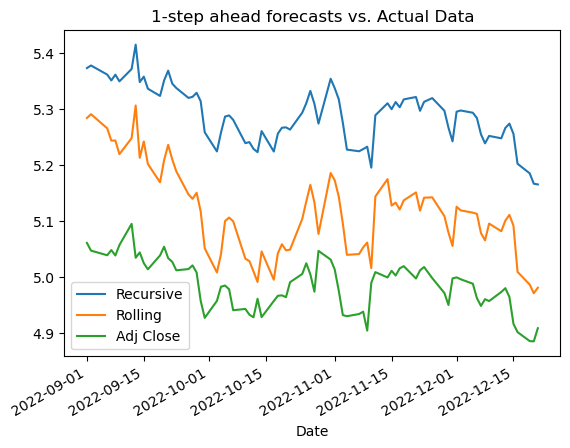


 forecasts 
                 Fixed  Recursive   Rolling  Adj Close
Date                                                 
2022-09-01   5.212616   5.372622  5.283546   5.060684
2022-09-02   5.373939   5.377236  5.290395   5.046980
2022-09-06   5.516862   5.361007  5.265074   5.038731
2022-09-07   5.665241   5.350605  5.243247   5.047942
2022-09-08   5.831080   5.360835  5.243408   5.038278
...               ...        ...       ...        ...
2022-12-15  16.554747   5.255184  5.091391   4.916325
2022-12-16  16.663387   5.201973  5.009125   4.901639
2022-12-19  16.805328   5.184822  4.986387   4.885601
2022-12-20  16.945918   5.166414  4.970939   4.885072
2022-12-21  17.102017   5.165025  4.980808   4.908603

[78 rows x 4 columns]

 MAE 
 Recursive    2.362447
Rolling      1.021278
dtype: float64

 RMSE 
 Recursive    0.849381
Rolling      0.390131
dtype: float64


In [60]:
#=================== Plot forecasts and compute errors ===========================================================================    

# Plot the forecast overview of recursive and rolling windows against actual data  
forecast_overview.iloc[:,1:].plot()
plt.title('1-step ahead forecasts vs. Actual Data')
plt.show()


# Compute the MAE/RMSE and analyze full forecast table --> Select modeln with lowest RMSE
epsilon = forecast_overview.iloc[:,1:3].sub(obs.squeeze(), axis=0)
mae = epsilon.abs().sum(axis=0)/10
rmse = ((epsilon**2).sum(axis=0)/10)**.5
    
print('\n forecasts \n', forecast_overview)
print('\n MAE \n', mae) 
print('\n RMSE \n', rmse) 

In [80]:
#===== 20-step ahead forecasts =======================

# Adjusted close price
obs = df.loc[df_test.index].apply(np.log)

# Fixed window forecast
forecast_fixed = fixed_window(20, df_test, df).add(data_shifted.squeeze(),axis=0)

# Recursive window forecast
forecast_recursive = recursive_window(20, df_test, df).add(data_shifted.squeeze(),axis=0)

# Rolling window forecast
forecast_rolling = rolling_window(20, df_test, df).add(data_shifted.squeeze(),axis=0)

# Global forecast overview by merging outputs
list = [forecast_recursive,forecast_rolling, obs]
forecast_overview = forecast_fixed
for i in range(len(list)):
    forecast_overview = pd.merge(forecast_overview,list[i], left_index=True, right_index=True)

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6988.224375263742
Iteration:      2,   Func. Count:     17,   Neg. LLF: 50688.788218607224
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2035.7967747452835
Iteration:      4,   Func. Count:     34,   Neg. LLF: 2907.450255764102
Iteration:      5,   Func. Count:     42,   Neg. LLF: 2613.0891693163844
Iteration:      6,   Func. Count:     49,   Neg. LLF: 1495.985268203405
Iteration:      7,   Func. Count:     55,   Neg. LLF: 1495.939629341462
Iteration:      8,   Func. Count:     61,   Neg. LLF: 1495.93267560625
Iteration:      9,   Func. Count:     67,   Neg. LLF: 1495.9308522110632
Iteration:     10,   Func. Count:     73,   Neg. LLF: 1495.9306202116882
Iteration:     11,   Func. Count:     79,   Neg. LLF: 1495.9305506424141
Iteration:     12,   Func. Count:     85,   Neg. LLF: 1495.9305500126916
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1495.9305500126916
            Iteration

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6191.469523541744
Iteration:      2,   Func. Count:     17,   Neg. LLF: 53530.82341780863
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2618.0613586163918
Iteration:      4,   Func. Count:     35,   Neg. LLF: 2589.2360442809377
Iteration:      5,   Func. Count:     43,   Neg. LLF: 2400.9612177161716
Iteration:      6,   Func. Count:     50,   Neg. LLF: 2376.1381032933723
Iteration:      7,   Func. Count:     56,   Neg. LLF: 2375.9458284410453
Iteration:      8,   Func. Count:     62,   Neg. LLF: 2375.9206818712287
Iteration:      9,   Func. Count:     68,   Neg. LLF: 2375.916051058729
Iteration:     10,   Func. Count:     74,   Neg. LLF: 2375.91529843062
Iteration:     11,   Func. Count:     80,   Neg. LLF: 2375.914997532019
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2375.9149975320215
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2375.914997532019
            Iterations

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6242.3142258467815
Iteration:      2,   Func. Count:     17,   Neg. LLF: 53612.31732509449
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2638.2713224743447
Iteration:      4,   Func. Count:     35,   Neg. LLF: 2611.251204168425
Iteration:      5,   Func. Count:     43,   Neg. LLF: 2448.5868604725415
Iteration:      6,   Func. Count:     50,   Neg. LLF: 2394.0858988836953
Iteration:      7,   Func. Count:     56,   Neg. LLF: 2393.90403991599
Iteration:      8,   Func. Count:     62,   Neg. LLF: 2393.8832135359953
Iteration:      9,   Func. Count:     68,   Neg. LLF: 2393.879297123193
Iteration:     10,   Func. Count:     74,   Neg. LLF: 2393.8786702704856
Iteration:     11,   Func. Count:     80,   Neg. LLF: 2393.878427884586
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2393.8784278845887
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2393.878427884586
            Iterations

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6348.370114392085
Iteration:      2,   Func. Count:     17,   Neg. LLF: 54083.76995541248
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2675.207719868928
Iteration:      4,   Func. Count:     34,   Neg. LLF: 2632.173730165736
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3561.871199612451
Iteration:      6,   Func. Count:     49,   Neg. LLF: 2417.498420413651
Iteration:      7,   Func. Count:     55,   Neg. LLF: 2417.3763646736197
Iteration:      8,   Func. Count:     61,   Neg. LLF: 2417.359206793298
Iteration:      9,   Func. Count:     67,   Neg. LLF: 2417.3563292261183
Iteration:     10,   Func. Count:     73,   Neg. LLF: 2417.3557026187086
Iteration:     11,   Func. Count:     79,   Neg. LLF: 2417.3555334224416
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2417.355532726352
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2417.355532726352
            Iterations: 

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6387.666015310387
Iteration:      2,   Func. Count:     17,   Neg. LLF: 54463.33066052478
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2691.401564907676
Iteration:      4,   Func. Count:     35,   Neg. LLF: 2652.856539469685
Iteration:      5,   Func. Count:     43,   Neg. LLF: 2545.5883662883725
Iteration:      6,   Func. Count:     50,   Neg. LLF: 2436.4792391430074
Iteration:      7,   Func. Count:     56,   Neg. LLF: 2436.2788547017117
Iteration:      8,   Func. Count:     62,   Neg. LLF: 2436.255901781861
Iteration:      9,   Func. Count:     68,   Neg. LLF: 2436.2516177485945
Iteration:     10,   Func. Count:     74,   Neg. LLF: 2436.251009329122
Iteration:     11,   Func. Count:     80,   Neg. LLF: 2436.250797921005
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2436.2507979210077
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2436.250797921005
            Iterations:

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6429.071502072134
Iteration:      2,   Func. Count:     17,   Neg. LLF: 55971.37281655866
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2715.9021011616064
Iteration:      4,   Func. Count:     34,   Neg. LLF: 2678.6392146404633
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3629.578439363765
Iteration:      6,   Func. Count:     49,   Neg. LLF: 2461.9261310109036
Iteration:      7,   Func. Count:     55,   Neg. LLF: 2461.811530668352
Iteration:      8,   Func. Count:     61,   Neg. LLF: 2461.797084207637
Iteration:      9,   Func. Count:     67,   Neg. LLF: 2461.7942083333755
Iteration:     10,   Func. Count:     73,   Neg. LLF: 2461.7936487198763
Iteration:     11,   Func. Count:     79,   Neg. LLF: 2461.7935261156135
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2461.7935255414386
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2461.7935255414386
            Iteratio

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6451.741259568644
Iteration:      2,   Func. Count:     17,   Neg. LLF: 55622.03591390703
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2738.4655129003395
Iteration:      4,   Func. Count:     34,   Neg. LLF: 2704.530100886028
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3634.4448941503338
Iteration:      6,   Func. Count:     49,   Neg. LLF: 2486.5109991884283
Iteration:      7,   Func. Count:     55,   Neg. LLF: 2486.322709767721
Iteration:      8,   Func. Count:     61,   Neg. LLF: 2486.2981635329998
Iteration:      9,   Func. Count:     67,   Neg. LLF: 2486.292856039431
Iteration:     10,   Func. Count:     73,   Neg. LLF: 2486.2920835164014
Iteration:     11,   Func. Count:     79,   Neg. LLF: 2486.291847504606
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2486.2918468743637
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2486.2918468743637
            Iteration

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6537.517048795715
Iteration:      2,   Func. Count:     17,   Neg. LLF: 54997.601041749294
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2773.0258871540414
Iteration:      4,   Func. Count:     34,   Neg. LLF: 2720.469419793555
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3662.492513464984
Iteration:      6,   Func. Count:     49,   Neg. LLF: 2505.6316769558457
Iteration:      7,   Func. Count:     55,   Neg. LLF: 2505.4746840434445
Iteration:      8,   Func. Count:     61,   Neg. LLF: 2505.4541592350106
Iteration:      9,   Func. Count:     67,   Neg. LLF: 2505.4503779859206
Iteration:     10,   Func. Count:     73,   Neg. LLF: 2505.4497713448754
Iteration:     11,   Func. Count:     79,   Neg. LLF: 2505.4495972691793
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2505.449596687074
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2505.449596687074
            Iteratio

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6574.378595818802
Iteration:      2,   Func. Count:     17,   Neg. LLF: 55435.37646544851
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2795.9917479286487
Iteration:      4,   Func. Count:     34,   Neg. LLF: 2740.081522979368
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3680.551412901895
Iteration:      6,   Func. Count:     49,   Neg. LLF: 2524.6776105000163
Iteration:      7,   Func. Count:     55,   Neg. LLF: 2524.521152735422
Iteration:      8,   Func. Count:     61,   Neg. LLF: 2524.4989783585206
Iteration:      9,   Func. Count:     67,   Neg. LLF: 2524.4952441108526
Iteration:     10,   Func. Count:     73,   Neg. LLF: 2524.4946343410365
Iteration:     11,   Func. Count:     79,   Neg. LLF: 2524.494450507138
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2524.494449942543
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2524.494449942543
            Iterations:

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6127.036947068842
Iteration:      2,   Func. Count:     17,   Neg. LLF: 53493.33514741059
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2613.6011344913977
Iteration:      4,   Func. Count:     35,   Neg. LLF: 2585.799352156153
Iteration:      5,   Func. Count:     43,   Neg. LLF: 2368.18389253269
Iteration:      6,   Func. Count:     50,   Neg. LLF: 2364.2844356146725
Iteration:      7,   Func. Count:     56,   Neg. LLF: 2364.1905906417633
Iteration:      8,   Func. Count:     62,   Neg. LLF: 2364.182036076054
Iteration:      9,   Func. Count:     68,   Neg. LLF: 2364.180074519385
Iteration:     10,   Func. Count:     74,   Neg. LLF: 2364.1797322899192
Iteration:     11,   Func. Count:     80,   Neg. LLF: 2364.179661065302
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2364.1796610652923
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2364.179661065302
            Iterations: 

Iteration:      9,   Func. Count:     68,   Neg. LLF: 2393.879297123193
Iteration:     10,   Func. Count:     74,   Neg. LLF: 2393.8786702704856
Iteration:     11,   Func. Count:     80,   Neg. LLF: 2393.878427884586
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2393.8784278845887
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2393.878427884586
            Iterations: 12
            Function evaluations: 85
            Gradient evaluations: 12
Iteration:      1,   Func. Count:      7,   Neg. LLF: 6245.817316927369
Iteration:      2,   Func. Count:     17,   Neg. LLF: 53419.411451148524
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2639.963067154923
Iteration:      4,   Func. Count:     35,   Neg. LLF: 2612.841307617851
Iteration:      5,   Func. Count:     43,   Neg. LLF: 2487.202969819906
Iteration:      6,   Func. Count:     50,   Neg. LLF: 2395.5646519109687
Iteration:      7,   Func. Count:     57,   Neg. LLF: 2395.36710913

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6358.287812246249
Iteration:      2,   Func. Count:     17,   Neg. LLF: 54313.51709734937
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2680.0040220491246
Iteration:      4,   Func. Count:     35,   Neg. LLF: 2643.250656843673
Iteration:      5,   Func. Count:     43,   Neg. LLF: 2520.8049665019144
Iteration:      6,   Func. Count:     50,   Neg. LLF: 2425.8001226749375
Iteration:      7,   Func. Count:     56,   Neg. LLF: 2425.5978603643002
Iteration:      8,   Func. Count:     62,   Neg. LLF: 2425.5740339820686
Iteration:      9,   Func. Count:     68,   Neg. LLF: 2425.569657711583
Iteration:     10,   Func. Count:     74,   Neg. LLF: 2425.5690411152887
Iteration:     11,   Func. Count:     80,   Neg. LLF: 2425.5688296188264
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2425.568829618828
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2425.5688296188264
            Iteratio

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6379.538586005714
Iteration:      2,   Func. Count:     17,   Neg. LLF: 56087.07394322388
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2701.847242286559
Iteration:      4,   Func. Count:     35,   Neg. LLF: 2673.5935729449857
Iteration:      5,   Func. Count:     43,   Neg. LLF: 2585.3312226337807
Iteration:      6,   Func. Count:     50,   Neg. LLF: 2456.623374171858
Iteration:      7,   Func. Count:     56,   Neg. LLF: 2456.439746147356
Iteration:      8,   Func. Count:     62,   Neg. LLF: 2456.4178650011427
Iteration:      9,   Func. Count:     68,   Neg. LLF: 2456.4131289780544
Iteration:     10,   Func. Count:     74,   Neg. LLF: 2456.4124231083206
Iteration:     11,   Func. Count:     80,   Neg. LLF: 2456.4122307657467
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2456.412230765747
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2456.4122307657467
            Iteration

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6464.978106155534
Iteration:      2,   Func. Count:     17,   Neg. LLF: 55324.24817539286
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2741.603570355261
Iteration:      4,   Func. Count:     34,   Neg. LLF: 2705.5505204498577
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3636.687537409417
Iteration:      6,   Func. Count:     49,   Neg. LLF: 2488.525949698256
Iteration:      7,   Func. Count:     55,   Neg. LLF: 2488.33149793431
Iteration:      8,   Func. Count:     61,   Neg. LLF: 2488.3057154426224
Iteration:      9,   Func. Count:     67,   Neg. LLF: 2488.30022770726
Iteration:     10,   Func. Count:     73,   Neg. LLF: 2488.2994243110725
Iteration:     11,   Func. Count:     79,   Neg. LLF: 2488.2991728981688
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2488.2991721629614
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2488.2991721629614
            Iterations: 

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6539.510657269488
Iteration:      2,   Func. Count:     17,   Neg. LLF: 55419.85147791616
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2779.076027407281
Iteration:      4,   Func. Count:     34,   Neg. LLF: 2730.2245533757523
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3666.9913134768576
Iteration:      6,   Func. Count:     49,   Neg. LLF: 2514.8577214297984
Iteration:      7,   Func. Count:     55,   Neg. LLF: 2514.675680865143
Iteration:      8,   Func. Count:     61,   Neg. LLF: 2514.6505164294044
Iteration:      9,   Func. Count:     67,   Neg. LLF: 2514.645830625609
Iteration:     10,   Func. Count:     73,   Neg. LLF: 2514.6451248395842
Iteration:     11,   Func. Count:     79,   Neg. LLF: 2514.64490617568
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2514.6449054812533
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2514.6449054812533
            Iterations

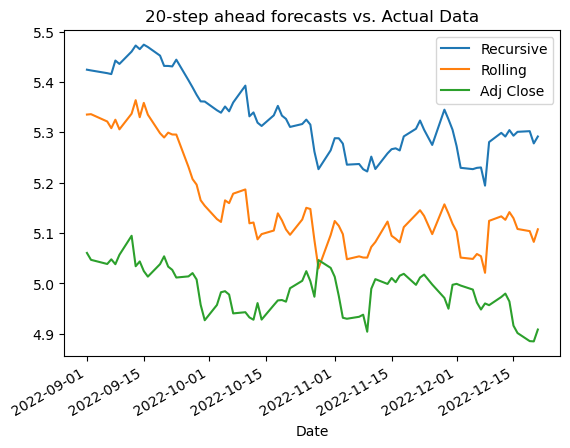


 forecasts 
                 Fixed  Recursive   Rolling  Adj Close
Date                                                 
2022-09-01   5.264425   5.424430  5.335355   5.060684
2022-09-02   5.419662   5.422959  5.336118   5.046980
2022-09-06   5.573382   5.417527  5.321594   5.038731
2022-09-07   5.730313   5.415677  5.308319   5.047942
2022-09-08   5.912798   5.442553  5.325126   5.038278
...               ...        ...       ...        ...
2022-12-15  16.592971   5.293408  5.129615   4.916325
2022-12-16  16.762486   5.301072  5.108224   4.901639
2022-12-19  16.922888   5.302382  5.103947   4.885601
2022-12-20  17.057597   5.278092  5.082617   4.885072
2022-12-21  17.228779   5.291787  5.107570   4.908603

[78 rows x 4 columns]

 MAE 
 Recursive    2.669803
Rolling      1.331938
dtype: float64

 RMSE 
 Recursive    0.972026
Rolling      0.518046
dtype: float64


In [78]:
#=================== Plot forecasts and compute errors ===========================================================================    

# Plot the forecast overview of recursive and rolling windows against actual data  
forecast_overview.iloc[:,1:].plot()
plt.title('20-step ahead forecasts vs. Actual Data')
plt.show()


# Compute the MAE/RMSE and analyze full forecast table --> Select modeln with lowest RMSE
epsilon = forecast_overview.iloc[:,1:3].sub(obs.squeeze(), axis=0)
mae = epsilon.abs().sum(axis=0)/10
rmse = ((epsilon**2).sum(axis=0)/10)**.5
    
print('\n forecasts \n', forecast_overview)
print('\n MAE \n', mae) 
print('\n RMSE \n', rmse) 

<div style="text-align: justify">According to the forecast visual representation and RMSE, we infer that the <strong>rolling window is the most accurate</strong> way to forecast data. In addition, the ouputs are relevant since higher RMSE are noticed for the 20-step ahead forecast. This illustrate the decreasing function of forecasting power / accuracy with respect to time. </div> 

## Step 4: VaR computations:

In [ ]:
print(t.ppf(0.05,9.4548))
print(norm.ppf(0.05))

In [ ]:
#================== In-sample Value-at-Risk estimates=================

#======= GARCH(1,1) estimates =====================================

arch = arch_model(df_train_std,p=1, o=0, q=1, mean='AR', lags=0, dist='t') 
res = arch.fit()
print(res.summary())
fig = res.plot(annualize='D')


temp = res.conditional_volatility
var90 = (0.0656 + res.conditional_volatility * t.ppf(0.10,9.2571)) /100
var95 = (0.0656 + res.conditional_volatility * t.ppf(0.05,9.2571)) /100
var99 = (0.0656 + res.conditional_volatility * t.ppf(0.01,9.2571)) /100
    
fig = plt.figure(figsize=(12,8))
plt.plot(df_train_std, 'b.', var90, 'r-', var95, 'g-', var99, 'c-')
plt.tight_layout()
 
print(np.mean(df_train_std < var90))  
print(np.mean(df_train_std < var95)) 
print(np.mean(df_train_std < var99))

**PAUL: Ok donc ici la vol dans les returns est vachement large, on voit à peine la diff entre les différentes VaR. Bon à analyser/commenter.** 

In [ ]:
#============= Out-of-sample Value-at-Risk estimates ===========================

# Define 99% VaR study and the size of the out-of-sample study 
alpha = 0.01
oos = 78
nb_obs = len(df_logret)

# Prepare to fill the Out-of-sample VaR's in df
VaR_oss = pd.DataFrame(index=range(0,nb_obs), columns=['VaR_sd','VaR_GARCH','VaR_GJR','VaR_GARCHstd'])

# Loop through the sample to compute each model VaR
for x in range(nb_obs-oos, nb_obs):
    VaR_oss.iloc[x,VaR_oss.columns.get_loc("VaR_sd")] = np.std(df_test, axis=0) * norm.ppf(alpha) 
    arch_res = arch_model(df_test,p=1, o=0, q=0, dist='Normal').fit()
    arch_res_forecast = arch_res.forecast(horizon=1)
    VaR_oss.iloc[x,VaR_oss.columns.get_loc("VaR_GARCH")] = np.sqrt(arch_res_forecast.variance.values[-1, 0]) * norm.ppf(alpha)
    gjr_res = arch_model(df_test,p=1, o=1, q=1, dist='Normal').fit()
    gjr_res_forecast = arch_res.forecast(horizon=1)
    VaR_oss.iloc[x,VaR_oss.columns.get_loc("VaR_GJR")] = np.sqrt(gjr_res_forecast.variance.values[-1, 0]) * norm.ppf(alpha)
    garchSTD_res = arch_model(df_test,p=1, o=0, q=1, dist='t').fit()
    garchSTD_res_forecast = garchSTD_res.forecast(horizon=1)
    VaR_oss.iloc[x,VaR_oss.columns.get_loc("VaR_GARCHstd")] = np.sqrt(garchSTD_res_forecast.variance.values[-1, 0]) * t.ppf(alpha,garchSTD_res.params[-1])

In [ ]:
# Visualize the VaR Data -> Idea for the plot
VaR_oss = VaR_oss.dropna()
VaR_oss
# We see that the VaR is constant -> Plot makes sense

In [ ]:
plt.clf()
plt.plot(VaR_oss['VaR_sd'], 'k', label='VaR sd',linewidth=0.6)
plt.plot(VaR_oss['VaR_GARCH'], 'r', label='VaR GARCH',linewidth=0.6)
plt.plot(VaR_oss['VaR_GJR'], 'y', label='VaR GJR',linewidth=0.6)
plt.plot(VaR_oss['VaR_GARCHstd'], 'g', label='VaR GARCHstd',linewidth=0.6)
plt.xlim(nb_obs-oos, nb_obs)
plt.legend(loc='best', fontsize=9)

In [ ]:
#============= In and Out-of-sample Value-at-Risk estimates ===========================

# Compute VaR 90%, 95%, and 99% using quantile method --> Careful in Lab3 Sylvain only focused on 99% VaR
Varin_90 = df_train.quantile(0.1).round(4)
Varin_95 = df_train.quantile(0.05).round(4)
Varin_99 = df_train.quantile(0.01).round(4)
Varout_90 = df_test.quantile(0.1).round(4)
Varout_95 = df_test.quantile(0.05).round(4)
Varout_99 = df_test.quantile(0.01).round(4)

# Check for exceptions
Vin90 = 0
Vin95 = 0
Vin99 = 0
Vout90 = 0
Vout95 = 0
Vout99 = 0
for i in df_train:
    if i < Varin_90:
        Vin90 += 1
    if i < Varin_95:
        Vin95 += 1
    if i < Varin_99:
        Vin99 += 1
for j in df_test:
    if j < Varout_90:
        Vout90 += 1
    if j < Varout_95:
        Vout95 += 1
    if j < Varout_99:
        Vout99 += 1
        
# Prepare dataframe to visualize overall data
CL = ['90%', '95%', '99%']
IS_VAR = [Varin_90, Varin_95, Varin_99]
IS_Excep = [Vin90, Vin95,Vin99]
OOS_VAR = [Varout_90, Varout_95, Varout_99]
OOS_Excep = [Vout90, Vout95,Vout99]
df_VaR = pd.DataFrame.from_dict({ 'Confidence Level': CL,
                                    'In-Sample VaR': IS_VAR,
                                    'In-Sample Exceptions': IS_Excep,
                                    'Out-of-Sample VaR': OOS_VAR,
                                    'In-Sample Exceptions': OOS_Excep,})
df_VaR